## Splitting the data into train and test

These are some commonly used splitting strategies:

- Train-Test Split: Shuffling the data randomly and dividing into training and testing blocks
- Stratified Split: As we said the testing data distribution should match as close as possible to training distribution, the data should be split in such a manner that if training data contains 80% of 1 labels and 20% of 0 labels, testing data contains labels in similar proportions.
- Cross-Validation: Splitting your data once and getting high (low)-performance metrics can be a fluke. Your data was splitted in such a random sense that got you a high accuracy or a poor accuracy and so your model performance can be over/under-estimated with checking on a single split. Plus you are not looking at complete available data (you are using only 80% of data for training when you can use 100%). So you split data into say 5 blocks, train on 4 blocks and test on left block, and you do this 5 times. This is called K-Fold Cross-Validation.
- Stratified K-Fold CV: Combining 2 and 3, making sure that the 1 test block and 4 train blocks contain the same data distribution. This basically means that every (1/K) block contains the same data distribution.
- ShuffleSplit: Sample train and test sets for given number of iterations. Unlike Cross-Validation, wherein you shuffle the data once in start before making training and testing folds, in ShuffleSplit, you shuffle for every iteration and make train and test folds so there is a possibility that a particular example never went into testing (or training) fold. Another advantage is that you can specify sizes of training and testing sets, which means you have the option to only use a part of data for training and testing purposes unlike Train-Test Split or Cross Validation which make use of complete data.
- Stratified Shuffle Split: Combining 5. and 2. - ShuffleSplit with Stratification i.e. sampling training and testing sets keeping class distribution in mind.

Reference: https://www.kaggle.com/discussions/general/303076n mind.

In [28]:
X = power_transformerd_df[float_feature_variables]
y = df['delay_probability']

# Chia tệp dữ liệu thành 3 tệp: training, test và validation với tỷ lệ 70%, 15% và 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=100)

In [30]:
# Kiểm tra shape của 3 tệp
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((22445, 21), (4810, 21), (4810, 21), (22445,), (4810,), (4810,))

<Axes: xlabel='delay_probability', ylabel='Density'>

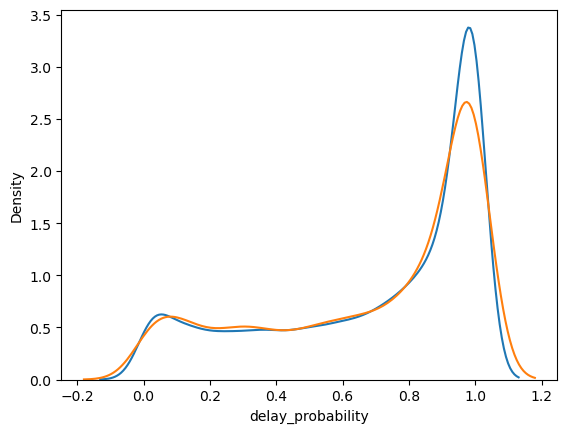

In [26]:
# Đánh giá phân bổ của biến phụ thuộc sau khi split dữ liệu
y_train_df = pd.DataFrame(y_train, columns=['delay_probability'])
y_test_df = pd.DataFrame(y_test, columns=['delay_probability'])

sns.kdeplot(data=y_train_df, x='delay_probability')
sns.kdeplot(data=y_test_df, x='delay_probability')

In [480]:
from scipy.stats import ks_2samp

#  KS statistic: a measure to compare empirical cumulative distribution functions (ECDFs) of two samples
stat, p_value = ks_2samp(y_train_df['delay_probability'], y_test_df['delay_probability'])

print(f"KS Statistic: {stat:.4f}")
print(f"P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("The two distributions are significantly different.")
else:
    print("The two distributions are not significantly different.")

KS Statistic: 0.0155
P-Value: 0.2927
The two distributions are not significantly different.


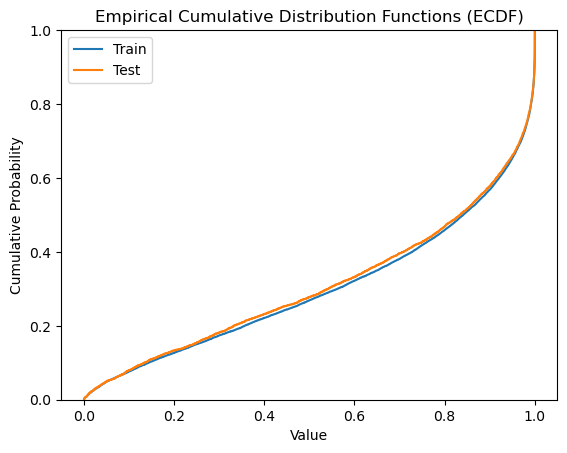

In [482]:
# Plot ECDFs
sns.ecdfplot(y_train_df['delay_probability'], label="Train")
sns.ecdfplot(y_test_df['delay_probability'], label="Test")
plt.title('Empirical Cumulative Distribution Functions (ECDF)')
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

## Feature selection

### Boruta

In [179]:
from boruta import BorutaPy
# Khởi tạo Boruta
feat_selector = BorutaPy(rf_model, n_estimators='auto', verbose=2, random_state=1, max_iter = 10) # số lần thử
feat_selector.fit(np.array(X_train), np.array(y_train))
feat_selector.support_
feat_selector.ranking_
feature_ranks = list(zip(X_train.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_))

for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	0
Tentative: 	4
Rejected: 	17
Iteration: 	9 / 10
Confirmed: 	0
Tentative: 	4
Rejected: 	17


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	0
Tentative: 	0
Rejected: 	21
Feature: vehicle_gps_latitude      Rank: 9,  Keep: False
Feature: vehicle_gps_longitude     Rank: 11,  Keep: False
Feature: fuel_consumption_rate     Rank: 16,  Keep: False
Feature: eta_variation_hours       Rank: 2,  Keep: False
Feature: traffic_congestion_level  Rank: 4,  Keep: False
Feature: warehouse_inventory_level Rank: 4,  Keep: False
Feature: loadin

The output of Boruta categorizes features into three groups:

- Ranking 1: Confirmed features (These features carry some signals related to the target variable, so they should be retained.)
- Ranking 2: Tentative features (Boruta is uncertain about these features, and the decision is up to you.)
- Ranking 3 or higher: Rejected features (Features in this ranking are considered noise.)

The predicted features have a ranking greater than 3, so they were all eliminated. 

## Regression Modeling

### Polynomial Regression

In the cases with non-linear data, we can try to use polynomial to simulate the relationship between the output(prediction) and input(features).

In [64]:
# Khởi tạo model base
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet

poly_features = PolynomialFeatures()
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_poly, y_train)
y_pred_ridge = ridge_model.predict(X_test_poly)

ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Ridge MSE: {ridge_mse:.4f}")

Ridge MSE: 0.1081


In [66]:
lasso_model = Lasso()
lasso_model.fit(X_train_poly, y_train)
y_pred_lasso = lasso_model.predict(X_test_poly)

lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso MSE: {lasso_mse:.4f}")

Lasso MSE: 0.1067


In [68]:
elastic_model = ElasticNet()
elastic_model.fit(X_train_poly, y_train)
y_pred_elastic = elastic_model.predict(X_test_poly)

elastic_mse = mean_squared_error(y_test, y_pred_elastic)
print(f"Elastic Net MSE: {elastic_mse:.4f}")

Elastic Net MSE: 0.1067


Text(0, 0.5, 'Predicted Probability')

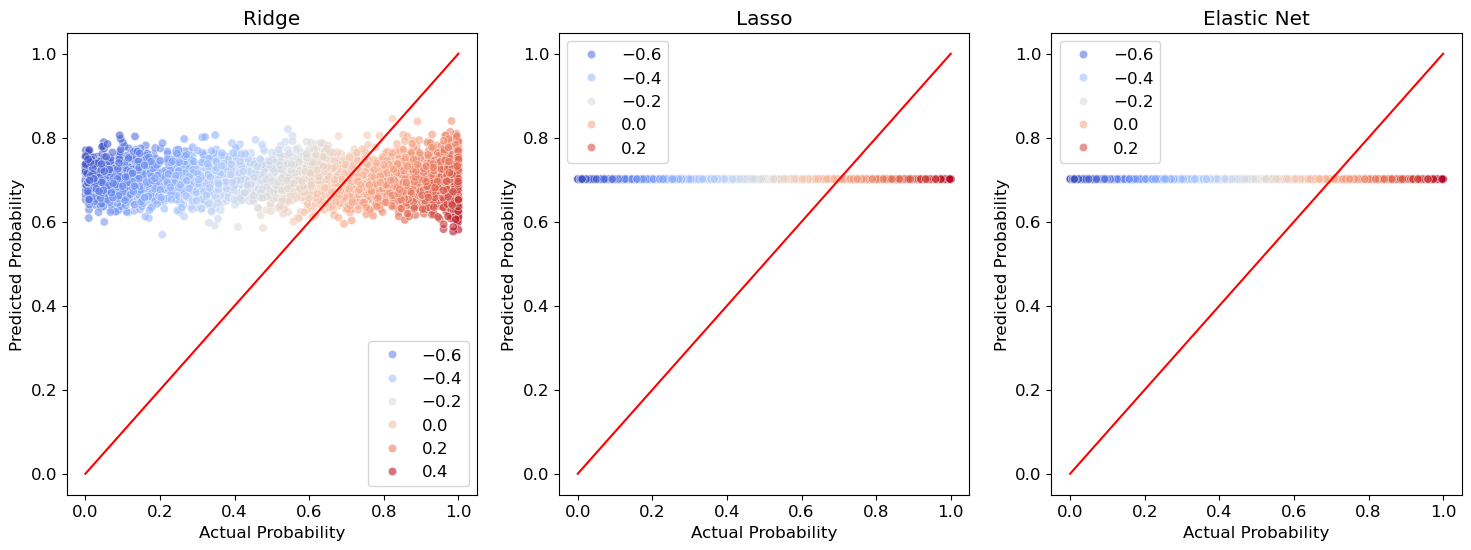

In [151]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_ridge = (y_test - y_pred_ridge)
residuals_lasso = (y_test - y_pred_lasso)
residuals_elastic = (y_test - y_pred_elastic)

# Trực quan
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
scatter = sns.scatterplot(ax=axes[0], x=y_test, y=y_pred_ridge, hue=residuals_ridge, palette='coolwarm', alpha=0.6)
sns.lineplot(ax=axes[0], x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')
axes[0].set_title('Ridge')
axes[0].set_xlabel('Actual Probability')
axes[0].set_ylabel('Predicted Probability')

scatter = sns.scatterplot(ax=axes[1], x=y_test, y=y_pred_lasso, hue=residuals_lasso, palette='coolwarm', alpha=0.6)
sns.lineplot(ax=axes[1], x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')
axes[1].set_title('Lasso')
axes[1].set_xlabel('Actual Probability')
axes[1].set_ylabel('Predicted Probability')

scatter = sns.scatterplot(ax=axes[2], x=y_test, y=y_pred_elastic, hue=residuals_elastic, palette='coolwarm', alpha=0.6)
sns.lineplot(ax=axes[2], x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')
axes[2].set_title('Elastic Net')
axes[2].set_xlabel('Actual Probability')
axes[2].set_ylabel('Predicted Probability')

In [135]:
# Tuning
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

# Prepare a range of polynomial degrees to try
degrees = range(2, 4)
n_alphas = 100
alphas = 1/np.logspace(1, -2, n_alphas) # Regularization strengths for Ridge/Lasso
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for degree in degrees:
    poly = PolynomialFeatures(degree=degree)
    
    # Transform features
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    for alpha in alphas:
        # Ridge Regression
        ridge_model = Ridge(alpha=alpha, fit_intercept=False)
        ridge_scores = cross_val_score(ridge_model, X_train_poly, y_train, cv=cv, scoring='neg_mean_squared_error', verbose=1)
        ridge_mse = -ridge_scores.mean()
        
        # Lasso Regression
        lasso_model = Lasso(alpha=alpha, max_iter=10000)
        lasso_scores = cross_val_score(lasso_model, X_train_poly, y_train, cv=cv, scoring='neg_mean_squared_error', verbose=1)
        lasso_mse = -lasso_scores.mean() 
        
        # ElasticNet Regression
        elasticnet_model = ElasticNet(alpha=alpha, l1_ratio= 0.5)
        elasticnet_scores = cross_val_score(elasticnet_model, X_train_poly, y_train, cv=cv, scoring='neg_mean_squared_error', verbose=1)
        elasticnet_mse = -elasticnet_scores.mean() 

        # Save the results
        results.append((degree, alpha, 'Ridge', ridge_mse))
        results.append((degree, alpha, 'Lasso', lasso_mse))
        results.append((degree, alpha, 'ElasticNet', elasticnet_mse))

# Find the best model
best_poly_model = min(results, key=lambda x: x[3])  # Lowest MSE
print(f"Best model: Degree {best_poly_model[0]}, Alpha {best_poly_model[1]}, Model {best_poly_model[2]} with MSE: {best_poly_model[3]}")

Best model: Degree 2, Alpha 0.1, Model Lasso with MSE: 0.10458020439409732


Note: Regularization methods like Ridge regression (L2) and Lasso regression (L1) can be used to handle non-linear relationships by penalizing the magnitude of the coefficients in a regression model. This penalty discourages the model from fitting the noise in the data and can result in a more generalized model. Regularization is especially helpful when dealing with multicollinearity or when you have more predictors than observations.
  
- Lasso Regression: The main purpose of Lasso regression is to perform feature selection by encouraging sparsity in the coefficient values. This means that it tends to shrink less important features towards zero, effectively excluding them from the model. Lasso regression can be helpful when dealing with high-dimensional datasets, where there are many potentially irrelevant features. By reducing the number of features, Lasso regression simplifies the model and improves interpretability.
  + Performs L1 regularization, i.e., adds penalty equivalent to the absolute value of the magnitude of coefficients
  + Minimization objective = LS Obj + α * (sum of the absolute value of coefficients)

- Ridge Regression: Ridge regression aims to reduce the impact of highly correlated features by shrinking their coefficients towards zero while keeping them non-zero. Unlike Lasso regression, Ridge regression does not perform explicit feature selection, as it generally keeps all features in the model. Instead, it reduces the magnitude of coefficients and helps to mitigate the effects of multicollinearity. Ridge regression is useful when dealing with multicollinearity issues, where independent variables are highly correlated, as it stabilizes the model and improves its generalization performance.
  + Performs L2 regularization, i.e., adds penalty equivalent to the square of the magnitude of coefficients
  + Minimization objective = LS Obj + α * (sum of square of coefficients)

The choice between Lasso regression and Ridge regression depends on the specific problem and the characteristics of the dataset:
- If feature selection is a primary concern and you want to identify the most important predictors, Lasso regression is a suitable choice.
- If multicollinearity is a concern and you want to reduce the impact of correlated features, Ridge regression is a suitable choice.
- In some cases, a combination of Lasso and Ridge regression can be used, known as Elastic Net regression, to balance between feature selection and handling multicollinearity.

Reference:
- https://www.linkedin.com/advice/3/how-can-you-handle-non-linear-relationships-regression-rrile
- https://medium.com/@sujathamudadla1213/why-we-have-to-use-lasso-regression-and-ridge-regression-a8d74bf4716flerrile

In [156]:
# Predict
best_poly_transformation = PolynomialFeatures(degree=best_poly_model[0])
X_train_best_poly = best_poly_transformation.fit_transform(X_train)
X_test_best_poly = best_poly_transformation.transform(X_test)

best_lasso_model = Lasso(alpha=best_poly_model[1], max_iter=10000)

best_lasso_model.fit(X_train_best_poly, y_train)
y_pred_best_poly = best_lasso_model.predict(X_test_best_poly)

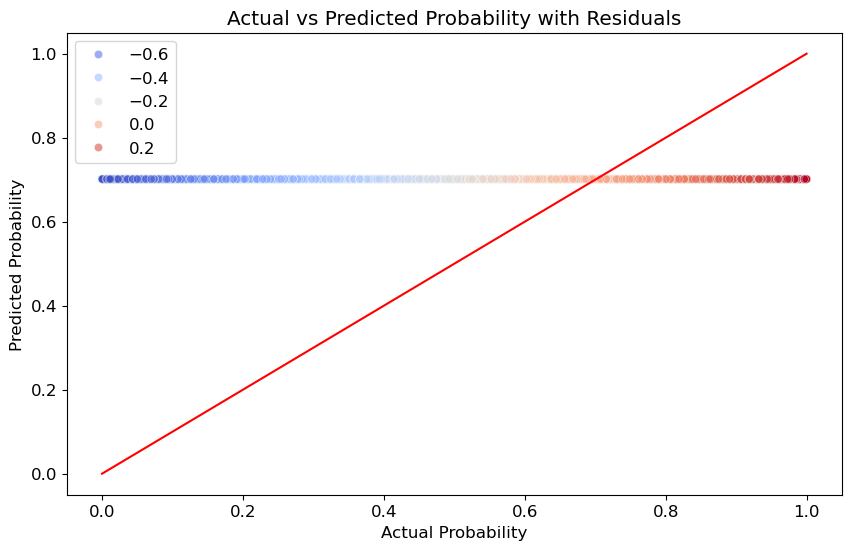

In [154]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_poly = (y_test - y_pred_best_poly)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_poly, hue=residuals_best_poly, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

### Decision Tree Regression

In general, decision trees are good at learning complex, non-linear relationships between the features and the target variable. They are non-parametric models that partition the feature space into regions that are separated by decision boundaries, based on the values of the features. They can easily capture interactions between features, and they don't require the data to be linearly separable. This makes them well-suited to handling a wide variety of data, including data with many features and complex relationships between the features and the target variable. 

In fact, tree-based algorithms are insensitive to the scale of the features since they are rule-based algorithms. A node in a decision tree splits by maximizing the information gain of a single feature and is not influenced by other features. Scaling this specific feature or scaling the others will not affect the information gain and homogeneity of the node. Hence, they are invariant to the scale of features and are robust to outliers.

In [158]:
# Khởi tạo model base
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=42)

tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

tree_mse = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {tree_mse:.4f}")

Decision Tree MSE: 0.2124


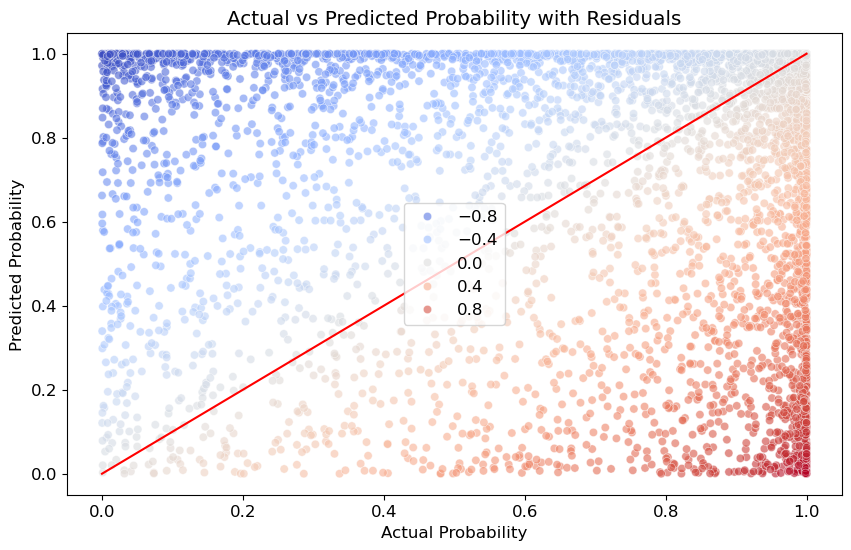

In [160]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_tree = (y_test - y_pred_tree)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_tree, hue=residuals_tree, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

In [60]:
# Độ sâu của model
print("Max Depth of Decision Tree:", tree_model.get_depth())

Max Depth of Decision Tree: 64


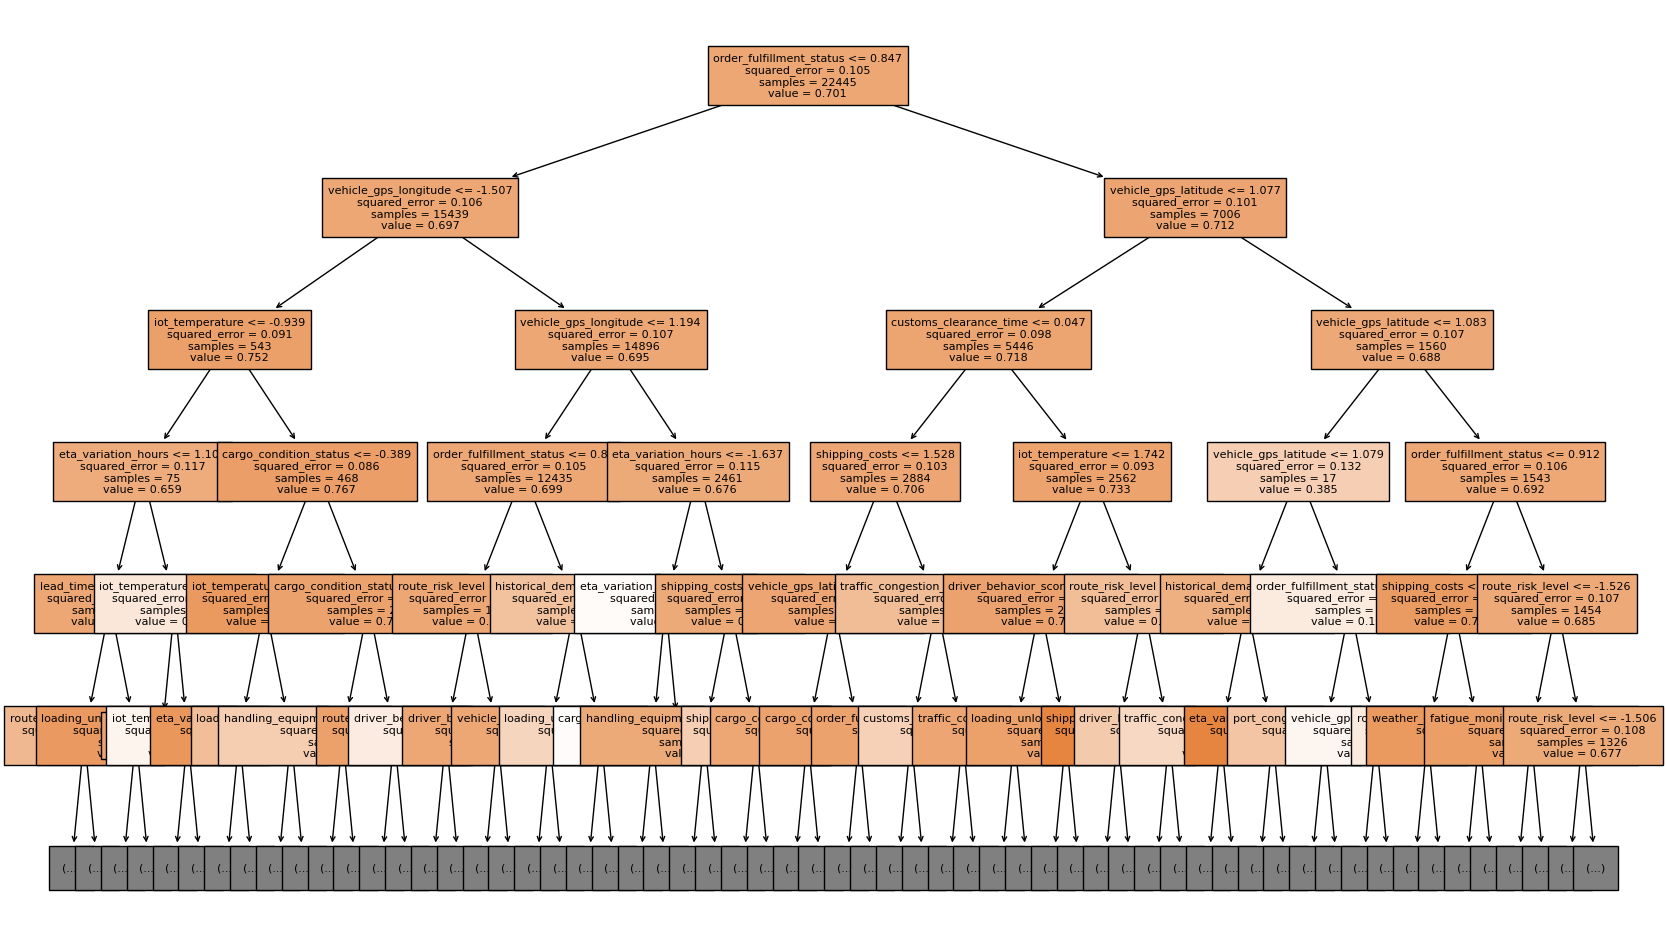

In [58]:
# Trực quan decision tree
from sklearn import tree
plt.figure(figsize=(20, 12))
tree.plot_tree(tree_model, max_depth=5, filled=True, feature_names=X_train.columns, fontsize=8)
plt.show()

In [103]:
# Feature Importance
tree_feature_importances = tree_model.feature_importances_

tree_feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tree_feature_importances,
})

tree_feature_importances_df = tree_feature_importances_df.sort_values(by='Importance', ascending=False)

print(tree_feature_importances_df)

                            Feature  Importance
19            driver_behavior_score    0.055344
0              vehicle_gps_latitude    0.053999
5         warehouse_inventory_level    0.053515
10            port_congestion_level    0.052506
11                   shipping_costs    0.050900
20         fatigue_monitoring_score    0.050591
8          order_fulfillment_status    0.048473
6            loading_unloading_time    0.048352
14                historical_demand    0.047858
17                 route_risk_level    0.047766
9        weather_condition_severity    0.047703
13                   lead_time_days    0.046766
2             fuel_consumption_rate    0.045980
15                  iot_temperature    0.045386
7   handling_equipment_availability    0.045000
4          traffic_congestion_level    0.044944
3               eta_variation_hours    0.044527
18           customs_clearance_time    0.044239
1             vehicle_gps_longitude    0.044202
12       supplier_reliability_score    0

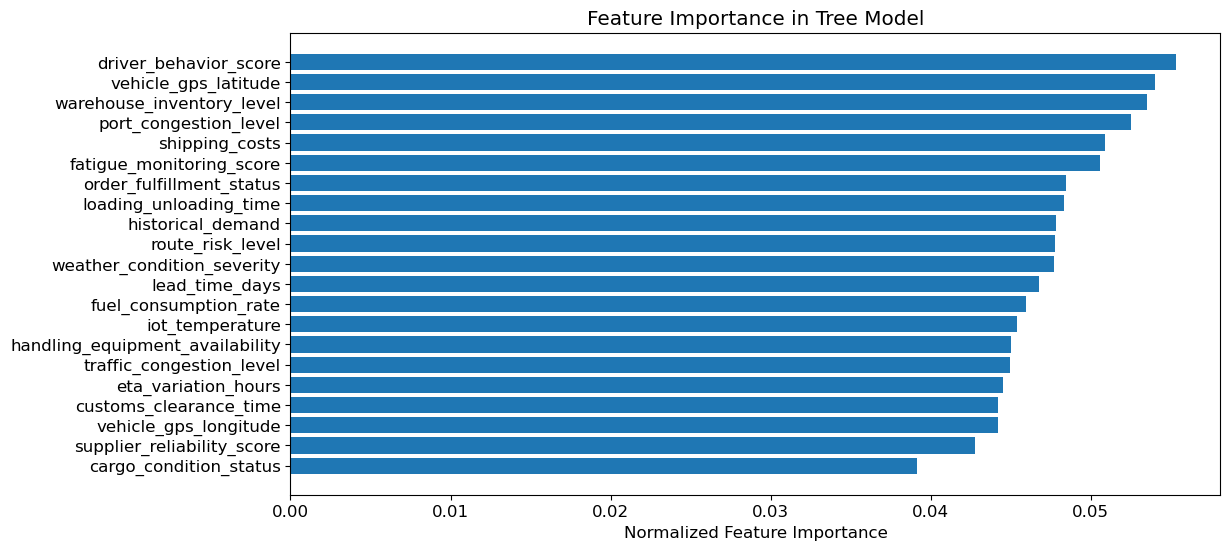

In [105]:
# Trực quan Feature Importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))

plt.barh(tree_feature_importances_df['Feature'], tree_feature_importances_df['Importance'])
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance in Tree Model')
plt.gca().invert_yaxis()
plt.show()

Top 6 importance features in Decision Tree:
- driver_behavior_score
- vehicle_gps_latitude
- warehouse_inventory_level
- port_congestion_level
- shipping_costs 
- fatigue_monitoring_score

In [80]:
# Độ sâu của Decision Tree lớn, cần tiếp tục tuning để tránh overfitting
# Tuning
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 5, 10, 15, None],  # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],    # Minimum number of samples required to be at a leaf node
    'max_features':[0.25,0.5,1.0] # Number of features to consider each time to make the split decision
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    cv=5,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit='neg_mean_squared_error',  # Prioritizing MSE
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

best_dtree_reg = grid_search.best_estimator_ # Get the best estimator from the grid search
y_pred = best_dtree_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Get the best parameters and the corresponding MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print(f"Best Decision Tree Parameters: {best_params}")
print(f"Best MSE: {best_mse}")

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Decision Tree Parameters: {'max_depth': 3, 'max_features': 0.25, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best MSE: 0.10491444419521405


In [86]:
# Predict
best_tree_model = grid_search.best_estimator_ 
y_pred_best_tree = best_tree_model.predict(X_test) 

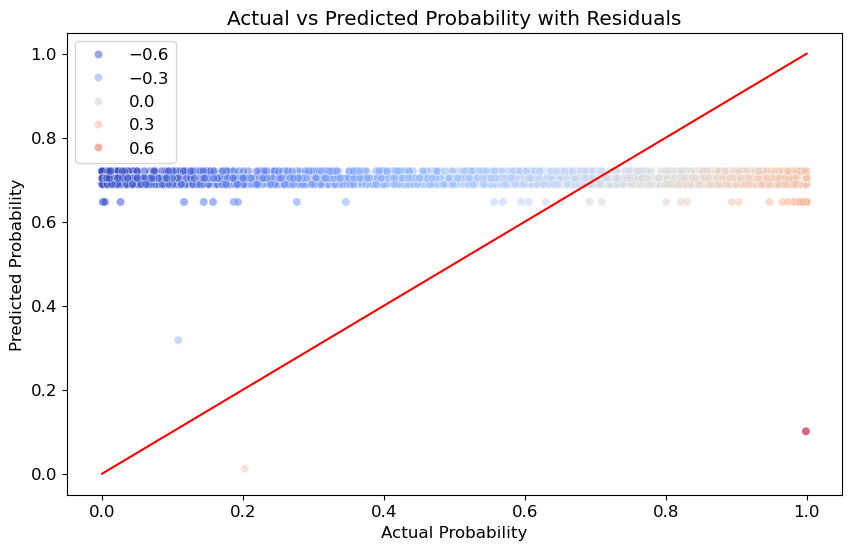

In [162]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_tree = (y_test - y_pred_best_tree)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_tree, hue=residuals_best_tree, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

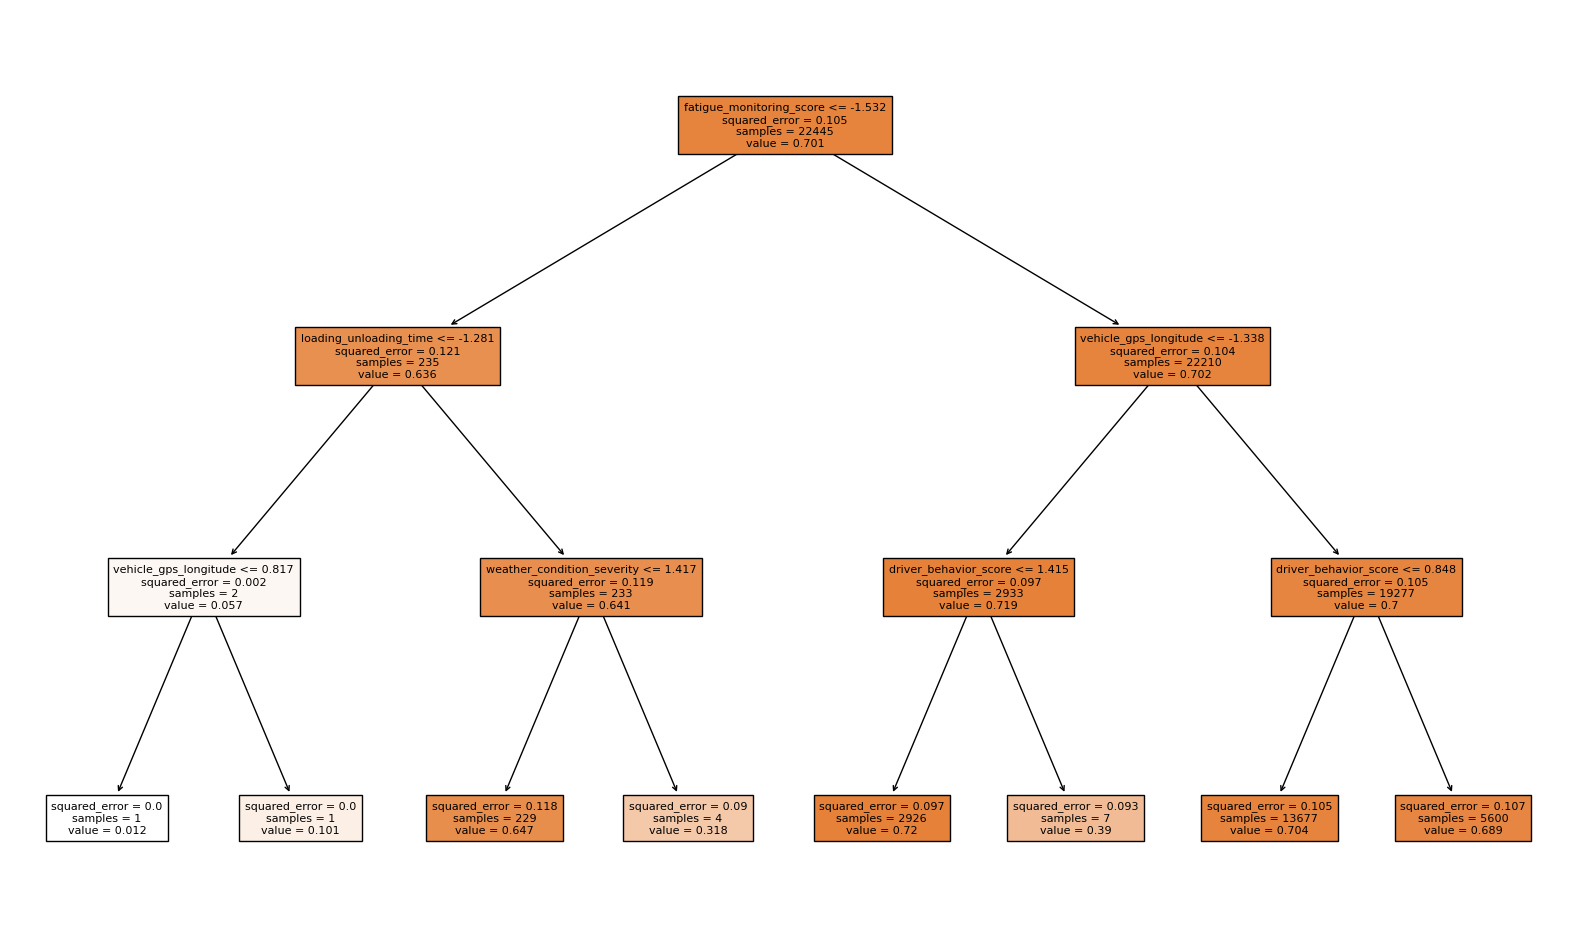

In [90]:
# Trực quan decision tree
from sklearn import tree
plt.figure(figsize=(20, 12))
tree.plot_tree(best_tree_model, max_depth=5, filled=True, feature_names=X_train.columns, fontsize=8)
plt.show()

In [92]:
# Feature Importance
best_tree_feature_importances = best_tree_model.feature_importances_

best_tree_feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_tree_feature_importances,
})

best_tree_feature_importances_df = best_tree_feature_importances_df.sort_values(by='Importance', ascending=False)

print(best_tree_feature_importances_df)

                            Feature  Importance
19            driver_behavior_score    0.334738
1             vehicle_gps_longitude    0.215257
20         fatigue_monitoring_score    0.214355
6            loading_unloading_time    0.144707
9        weather_condition_severity    0.090942
12       supplier_reliability_score    0.000000
18           customs_clearance_time    0.000000
17                 route_risk_level    0.000000
16           cargo_condition_status    0.000000
15                  iot_temperature    0.000000
14                historical_demand    0.000000
13                   lead_time_days    0.000000
0              vehicle_gps_latitude    0.000000
11                   shipping_costs    0.000000
8          order_fulfillment_status    0.000000
7   handling_equipment_availability    0.000000
5         warehouse_inventory_level    0.000000
4          traffic_congestion_level    0.000000
3               eta_variation_hours    0.000000
2             fuel_consumption_rate    0

Top 5 importance features in Decision Tree:
- driver_behavior_score
- vehicle_gps_latitude
- fatigue_monitoring_score
- loading_unloading_time
- weather_condition_severity

### Random Forest Regression

In [74]:
# Khởi tạo model base
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {rf_mse:.4f}")

Random Forest MSE: 0.1098


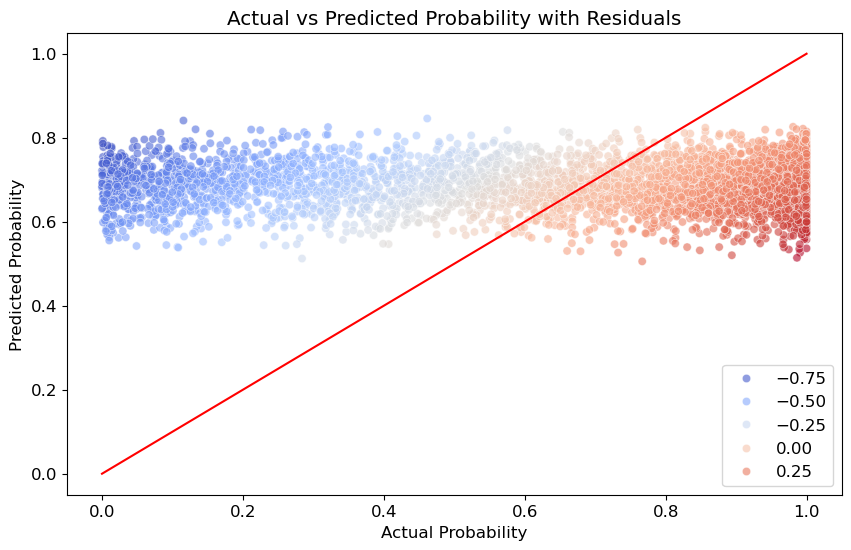

In [164]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_rf = (y_test - y_pred_rf)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_rf, hue=residuals_rf, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

In [150]:
# Feature Importance
rf_feature_importances = rf_model.feature_importances_

rf_feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances,
})

rf_feature_importances_df = rf_feature_importances_df.sort_values(by='Importance', ascending=False)

print(rf_feature_importances_df)

                            Feature  Importance
3               eta_variation_hours    0.050256
20         fatigue_monitoring_score    0.048797
4          traffic_congestion_level    0.048548
8          order_fulfillment_status    0.048503
13                   lead_time_days    0.048353
12       supplier_reliability_score    0.048292
9        weather_condition_severity    0.048132
5         warehouse_inventory_level    0.048082
17                 route_risk_level    0.048026
11                   shipping_costs    0.047656
19            driver_behavior_score    0.047383
1             vehicle_gps_longitude    0.047297
2             fuel_consumption_rate    0.047263
10            port_congestion_level    0.047028
14                historical_demand    0.046919
18           customs_clearance_time    0.046820
7   handling_equipment_availability    0.046685
15                  iot_temperature    0.046632
0              vehicle_gps_latitude    0.046549
6            loading_unloading_time    0

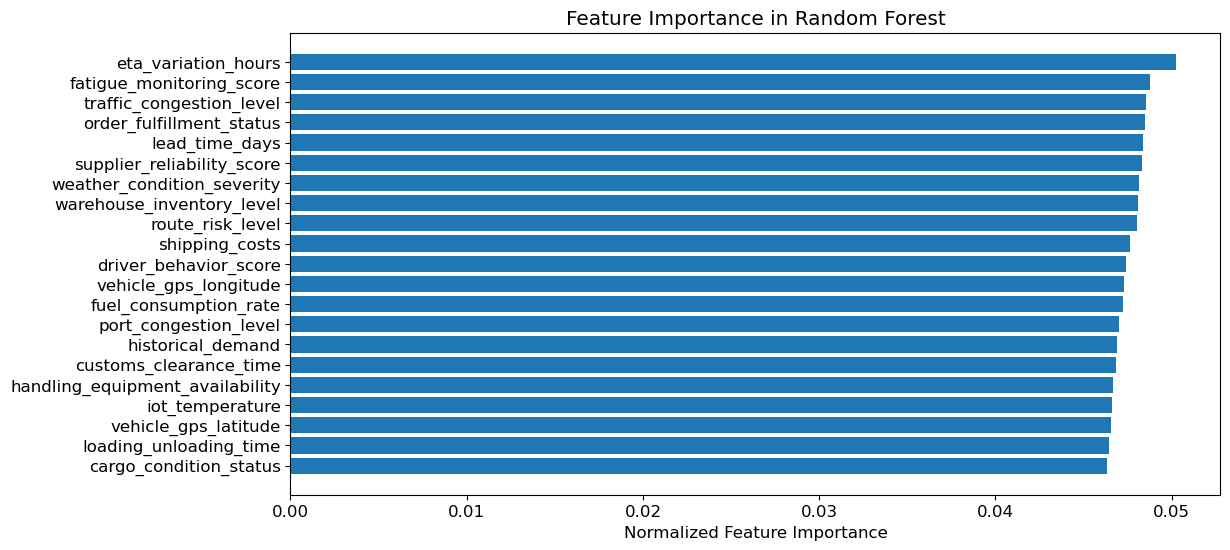

In [146]:
# Trực quan Feature Importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))

plt.barh(rf_feature_importances_df['Feature'], rf_feature_importances_df['Normalized Importance'])
plt.xlabel('Normalized Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

Top 6 importance features in Random Forest:

- eta_variation_hours
- fatigue_monitoring_score
- traffic_congestion_level
- order_fulfillment_status
- lead_time_days
- supplier_reliability_score

In [117]:
# Tuning

param_grid_rf = {
    'n_estimators': [50, 100, 150],  # Number of trees in the forest
    'max_depth': [3, 5, 10, 15, None],    # Max depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5],    # Minimum samples required to be at a leaf node
    'max_features': [0.25,0.5,1.0] # Number of features to consider each time to make the split decision
}

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and MSE from Grid Search
best_params_rf = grid_search_rf.best_params_
best_mse_rf = -grid_search_rf.best_score_

print(f"Best Random Forest Parameters: {best_params_rf}")
print(f"Best MSE on Training Data: {best_mse_rf}")

Best Random Forest Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best MSE on Training Data: 0.10458817174820045


In [114]:
# Predict 
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

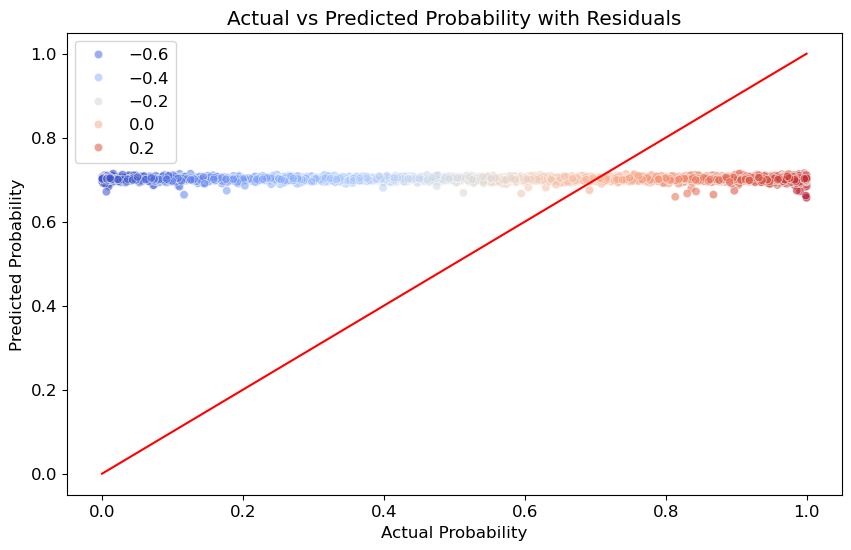

In [145]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_rf = (y_test - y_pred_best_rf)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_rf, hue=residuals_best_rf, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

### XGBoost Regression

In [75]:
# Khởi tạo model base
import xgboost as xgb

xgb_model = xgb.XGBRegressor(eval_metric='rmsle')

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Regression MSE: {xgb_mse:.4f}")

XGBoost Regression MSE: 0.1167


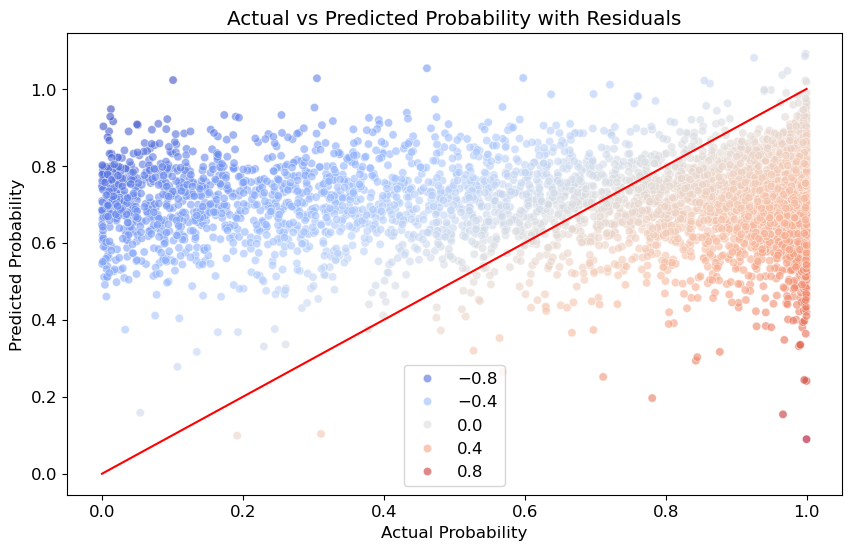

In [166]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_xgb = (y_test - y_pred_xgb)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_xgb, hue=residuals_xgb, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

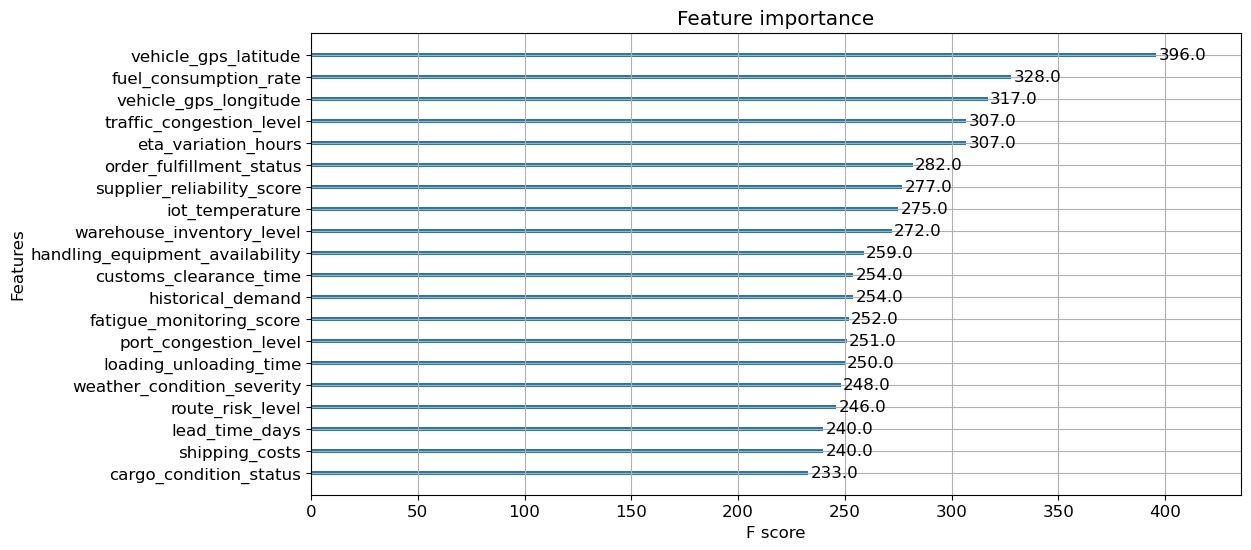

In [164]:
# Feature Importance 
from xgboost import plot_importance
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xgb_model, max_num_features=20, ax=ax)
plt.show()

Top 6 importance features in XGBoost Regression:

- vehicle_gps_latitude
- fuel_consumption_rate
- vehicle_gps_longtitude
- traffic_congestion_level
- eta_variation_hours
- order_fulfillment_status

In [121]:
# Tuning
param_grid = {"max_depth":    [5, 10, 15], # Maximum depth of a tree
              "n_estimators": [500, 600, 700], # Number of gradient boosted trees. Equivalent to number of boosting rounds.
              "learning_rate": [0.01, 0.015]} # Boosting learning rate

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ", grid_search_xgb.best_params_)

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}


In [125]:
# Predict
best_xgb_model=xgb.XGBRegressor(learning_rate = grid_search_xgb.best_params_["learning_rate"],
                                n_estimators  = grid_search_xgb.best_params_["n_estimators"],
                                max_depth     = grid_search_xgb.best_params_["max_depth"],
                                eval_metric='rmsle')

best_xgb_model.fit(X_train, y_train)

y_pred_best_xgb = best_xgb_model.predict(X_test)

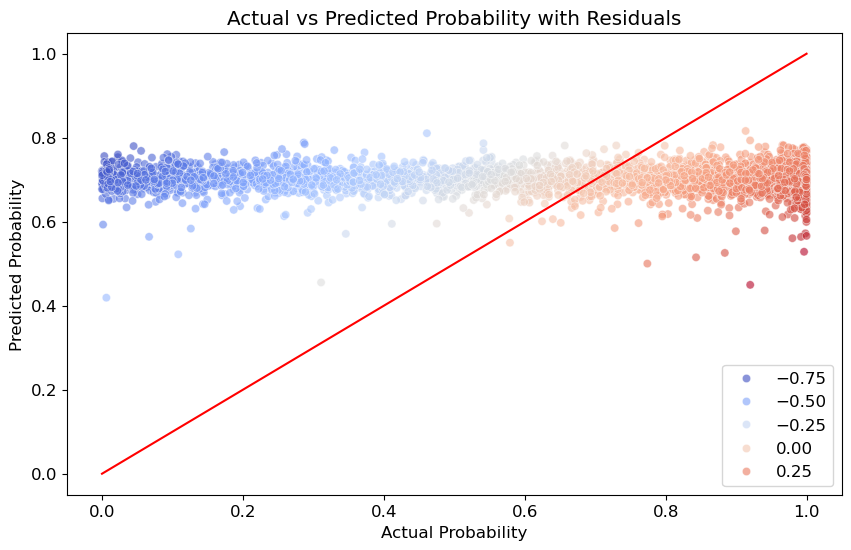

In [168]:
# Tính residuals (errors) giữa actual value và predicted value
residuals_best_xgb = (y_test - y_pred_best_xgb)

# Trực quan
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(x=y_test, y=y_pred_best_xgb, hue=residuals_best_xgb, palette='coolwarm', alpha=0.6)
sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red')

plt.title('Actual vs Predicted Probability with Residuals')
plt.xlabel('Actual Probability')
plt.ylabel('Predicted Probability')
plt.show()

## Evaluation on test set

There are three error metrics that are commonly used for evaluating and reporting the performance of a regression model; they are:

- Mean Absolute Error (MAE): It measures the average of the absolute differences between predicted and actual values. It’s a straightforward metric showing how far off predictions are in absolute terms.
- Mean Squared Error (MSE): It calculates the average of the squared differences between predicted and actual values. MSE penalizes larger errors more than MAE.
- Root Mean Squared Error (RMSE): It is the square root of the MSE. RMSE gives an idea of how large the errors are, in the same units as the target variable.
- Root Mean Squared Log Error (RMSLE): Similar to RMSE, but it applies the natural logarithm to predicted and actual values first. It’s useful when the target variable has exponential growth or when you care about relative errors rather than absolute differences.
- R Squared (R²): It measures the proportion of variance in the dependent variable that is predictable from the independent variables. A higher R² indicates a better fit of the model. It ranges from 0 (no fit) to 1 (perfect fit).

Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metricstricsMAE)

In [173]:
# Các metrics đánh giá
metrics = {'Model': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'R2': []}

# Mean Absolute Error (MAE) - Sai số tuyệt đối trung bình: MAE đo lường trung bình của các độ lệch tuyệt đối giữa giá trị dự đoán và giá trị thực tế.
# Mean Squared Error (MSE) - Sai số bình phương trung bình: MSE tính trung bình của các bình phương độ lệch giữa giá trị dự đoán và giá trị thực tế.
# Root Mean Squared Error (RMSE) - Căn bậc hai của sai số bình phương trung bình: RMSE là căn bậc hai của MSE, giúp đưa sai số về cùng đơn vị với biến mục tiêu.
# Root Mean Squared Log Error (RMSLE) - Căn bậc hai của sai số bình phương trung bình theo log: Giống như RMSE, nhưng trước khi tính toán, cả giá trị dự đoán và giá trị thực tế đều được chuyển đổi bằng hàm log tự nhiên. RMSLE phù hợp với các bài toán có biến mục tiêu tăng trưởng theo cấp số nhân hoặc khi sai số tương đối quan trọng hơn sai số tuyệt đối.
# R Squared (R²) - Hệ số xác định: R² đo lường tỷ lệ phương sai của biến phụ thuộc có thể giải thích được bởi các biến độc lập trong mô hình. Giá trị R² càng cao thì mô hình càng phù hợp, với phạm vi từ 0 (mô hình không giải thích được gì) đến 1 (mô hình hoàn hảo).

# Polynomial Regression
metrics['Model'].append('Polynomial Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_poly))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_poly))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_poly)))
metrics['R2'].append(r2_score(y_test, y_pred_best_poly))

# Decision Tree Regression
metrics['Model'].append('Decision Tree Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_tree))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_tree))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_tree)))
metrics['R2'].append(r2_score(y_test, y_pred_best_tree))

# Random Forest Regression
metrics['Model'].append('Random Forest Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_rf))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_rf))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_rf)))
metrics['R2'].append(r2_score(y_test, y_pred_best_rf))

# XGBoost Regression
metrics['Model'].append('XGBoost Regression')
metrics['MAE'].append(mean_absolute_error(y_test, y_pred_best_xgb))
metrics['MSE'].append(mean_squared_error(y_test, y_pred_best_xgb))
metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred_best_xgb)))
metrics['R2'].append(r2_score(y_test, y_pred_best_xgb))

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,MAE,MSE,RMSE,R2
0,Polynomial Regression,0.281022,0.106741,0.326712,-0.000635
1,Decision Tree Regression,0.281117,0.106907,0.326967,-0.002194
2,Random Forest Regression,0.281028,0.106758,0.326738,-0.000792
3,XGBoost Regression,0.281637,0.107447,0.327791,-0.007254


Since R² is negative, all models are ineffective. Even the best model (Polynomial Regression) is no better than simply predicting the mean.

**Conclusion:** Regarding the evaluation results of the four models, it is evident that the models fail to predict the delay probability of orders.

## Data Pipeline

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7)), # Xử lý missing data bằng cách dự báo KNN với n=7.
    ('scale', StandardScaler()), # Quy đổi tỷ lệ của các giá trị khác nhau để so sánh
    ('power', PowerTransformer(method='yeo-johnson')) # Biến đổi để phân phối của dữ liệu gần với phân phối chuẩn hơn
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, float_feature_variables)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scale', StandardScaler()),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['vehicle_gps_latitude',
                                  'vehicle_gps_longitude',
                                  'fuel_consumption_rate',
                                  'eta_variation_hours',
                                  'traffic_congestion_level',
                                  'warehouse_inventory_level',
                                  'loading_unloading_time',
                                  'handling_equipment_availability',
                                  'order_fulfillment_status',
                                  'weather_condition_severity',
                                  'port_congestion_level', 'shipping_costs',
                                  'supplier_reliability_score',
                                  'lead_time_days', 'historical_demand',
                                  'iot_temperature', 'cargo_condition_status',
                                  'route_risk_level', 'customs_clearance_time',
                                  'driver_behavior_score',
                                  'fatigue_monitoring_score'])])

In [214]:
import joblib

models = {
    "Polynomial Regression": Pipeline(steps=[
        ('poly_features', PolynomialFeatures(degree=2)),
        ('lasso', Lasso(alpha=0.1, max_iter=10000))
    ]),
    "Decision Tree": DecisionTreeRegressor(
        max_depth=3,  # Max depth of the tree
        max_features=0.25,  # Number of features to consider each time to make the split decision
        min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
        min_samples_split=2   # Minimum number of samples required to split an internal node
    ),
    "Random Forest": RandomForestRegressor(
        max_depth = 3, # Max depth of the trees
        max_features = 'sqrt', # Number of features to consider each time to make the split decision
        min_samples_leaf = 1, # Minimum samples required to be at a leaf node
        min_samples_split = 2, # Minimum samples required to split a node
        n_estimators = 150 # Number of trees in the forest
    ),
    "XGBoost": XGBRegressor(
        learning_rate = 0.01, # Boosting learning rate
        max_depth = 5, # Maximum depth of a tree
        n_estimators = 500 # Number of gradient boosted trees. Equivalent to number of boosting rounds.
    )
}
        
for name, regressor in models.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    joblib.dump(model, f'{name}_pipeline.pkl')
    print(f"{name} pipeline saved as {name}_pipeline.pkl")

Training Polynomial Regression...
Polynomial Regression pipeline saved as Polynomial Regression_pipeline.pkl
Training Decision Tree...
Decision Tree pipeline saved as Decision Tree_pipeline.pkl
Training Random Forest...
Random Forest pipeline saved as Random Forest_pipeline.pkl
Training XGBoost...
XGBoost pipeline saved as XGBoost_pipeline.pkl
